# Clustering-Based SHAP Networks for NHANES I dataset Random Forest Model

This notebook implements clustering-based aggregation to discover patient phenotypes with distinct disease mechanisms.

**Approach:** Cluster patients based on their SHAP value patterns, then build separate networks for each cluster. This may reveal distinct disease subtypes with different feature importance patterns and mechanisms.

**Mathematical Framework:**
- **Node weights** aggregate individual SHAP values across patients in each cluster
- **Edge weights** aggregate interaction values, with the denominator normalized using only the **lower triangular** interaction matrix (u > v), excluding diagonal elements

In [14]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

In [15]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [ ]:
# Load data
X = pd.read_pickle("../../../../data/nhanesi/x_values.pkl")
num_patients = 500
X_shapley = X.iloc[:num_patients, :]
shap_values = np.load("../../../../data/nhanesi/rf/shap_values.npy")
shap_interaction_values = np.load("../../../../data/nhanesi/rf/shap_interaction_values.npy")

## Prepare SHAP Values for Clustering

In [17]:
shap_features = np.nan_to_num(shap_values)

# Standardize for clustering
scaler = StandardScaler()
shap_features_scaled = scaler.fit_transform(shap_features)

## Determine Optimal Number of Clusters

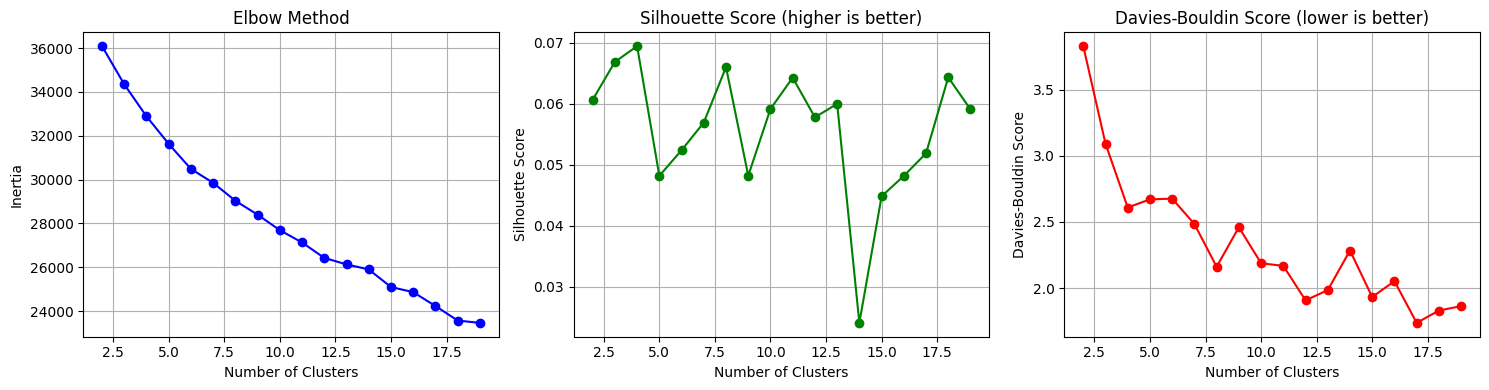


Clustering Metrics:
    n_clusters       inertia  silhouette  davies_bouldin
0            2  36090.707031    0.060640        3.828033
1            3  34347.195312    0.066836        3.090717
2            4  32888.914062    0.069412        2.608920
3            5  31629.617188    0.048183        2.670617
4            6  30487.699219    0.052371        2.675949
5            7  29854.472656    0.056909        2.483949
6            8  29034.210938    0.065986        2.160848
7            9  28400.558594    0.048204        2.460070
8           10  27693.076172    0.059134        2.187877
9           11  27132.396484    0.064249        2.167905
10          12  26428.361328    0.057761        1.907704
11          13  26132.884766    0.059972        1.984393
12          14  25902.400391    0.024104        2.284022
13          15  25100.445312    0.044821        1.932814
14          16  24866.539062    0.048176        2.052492
15          17  24235.527344    0.051861        1.737175
16        

In [18]:
# Test different numbers of clusters
k_range = range(2, 20)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(shap_features_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(shap_features_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(shap_features_scaled, labels))

# Plot elbow curve and metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(k_range, silhouette_scores, 'go-')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score (higher is better)')
axes[1].grid(True)

axes[2].plot(k_range, davies_bouldin_scores, 'ro-')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].set_title('Davies-Bouldin Score (lower is better)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Print metrics
metrics_df = pd.DataFrame({
    'n_clusters': list(k_range),
    'inertia': inertias,
    'silhouette': silhouette_scores,
    'davies_bouldin': davies_bouldin_scores
})
print("\nClustering Metrics:")
print(metrics_df)

## Perform Final Clustering

In [19]:
# Choose optimal k (you can adjust this based on the metrics above)
optimal_k = 4

# Perform final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(shap_features_scaled)

# Display cluster sizes
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print(f"\nFinal clustering with k={optimal_k}:")
for cluster_id, size in cluster_sizes.items():
    print(f"  Cluster {cluster_id}: {size} patients ({size/num_patients*100:.1f}%)")


Final clustering with k=4:
  Cluster 0: 10 patients (2.0%)
  Cluster 1: 250 patients (50.0%)
  Cluster 2: 24 patients (4.8%)
  Cluster 3: 216 patients (43.2%)


## Function to Build Network for Cluster

**Key Implementation Details:**

The function implements the following equations from the paper:

**Node weights (N*_i):**
$$\mathcal{N}^*_i = \frac{\sum_{t \in C_c} Sh_{i}(\Delta^{t})}{\sum_{u=1}^{n} \sum_{t \in C_c} |Sh_{u}(\Delta^{t})|}$$

**Edge weights (E*_ij):**
$$\mathcal{E}^*_{ij} = \frac{\sum_{t \in C_c} I_{ij}(\Delta^{t})}{\sum_{v=1}^{n} \sum_{u > v}^{n} \sum_{t \in C_c} I_{uv}(\Delta^{t})}$$

where $C_c$ denotes the set of patients in cluster $c$.

**Important:** The edge weight denominator sums only over the **lower triangular** part of the interaction matrix (where u > v), excluding diagonal elements. This differs from summing over all non-diagonal elements.

In [20]:
def build_network_for_cluster(cluster_mask, shap_values, shap_interaction_values, X_shapley):
    """
    Build psi and r matrices for a specific cluster
    
    Implements equations:
    - Node weights: N*_i = sum_t(Sh_i) / sum_u sum_t |Sh_u|
    - Edge weights: E*_ij = sum_t(I_ij) / sum_v sum_{u>v} sum_t |I_uv|
      where u>v denotes the lower triangular matrix (excluding diagonal)
    """
    # Filter SHAP values for this cluster
    cluster_shap = shap_values[cluster_mask]
    cluster_interaction = shap_interaction_values[cluster_mask]
    
    # Calculate psi_1 (node weights)
    # Numerator: sum over patients for each feature
    # Denominator: sum of absolute values over all patients and all features
    sum_shap = np.sum(np.abs(cluster_shap), axis=(0, 1))
    psi_1 = pd.DataFrame()
    psi_1['value'] = np.sum(cluster_shap, axis=0) / sum_shap
    psi_1.set_index(X_shapley.columns, inplace=True)
    
    # Calculate r_1 (edge weights) - use only lower triangular matrix for denominator
    n_patients_cluster = cluster_interaction.shape[0]
    n_variables = cluster_interaction.shape[1]
    
    # Clean NaN values
    filtered_interaction = np.nan_to_num(cluster_interaction.copy())
    
    # Create lower triangular mask (u > v means row > col, excluding diagonal)
    lower_tri_mask = np.tril(np.ones((n_variables, n_variables), dtype=bool), k=-1)
    
    # Calculate denominator: sum of absolute values of lower triangular elements only
    # sum_v sum_{u>v} sum_t |I_uv(Delta^t)|
    sum_interaction_lower = 0.0
    for patient_idx in range(n_patients_cluster):
        sum_interaction_lower += np.sum(np.abs(filtered_interaction[patient_idx][lower_tri_mask]))
    
    # Calculate numerator: sum over patients for each (i,j) pair
    # sum_t I_ij(Delta^t)
    cumulative_interaction = np.sum(filtered_interaction, axis=0)
    
    # Zero out diagonal (remove self-interactions)
    np.fill_diagonal(cumulative_interaction, 0)
    
    # Calculate edge weights: E*_ij = numerator / denominator
    r_1 = pd.DataFrame(cumulative_interaction / sum_interaction_lower)
    r_1.rename(columns=dict(list(zip(r_1.columns, X_shapley.columns))), inplace=True)
    r_1.set_index(X_shapley.columns, inplace=True)
    
    # Normalize
    psi_2 = normalize_psi(psi_1)
    r_2 = normalize_r(r_1)
    
    return psi_1, r_1, psi_2, r_2

## Build Networks for Each Cluster

In [21]:
# Build networks for each cluster
cluster_networks = {}

for cluster_id in range(optimal_k):
    cluster_mask = cluster_labels == cluster_id
    psi_1, r_1, psi_2, r_2 = build_network_for_cluster(
        cluster_mask, shap_features, shap_interaction_values, X_shapley
    )
    cluster_networks[cluster_id] = {
        'psi_1': psi_1,
        'r_1': r_1,
        'psi_2': psi_2,
        'r_2': r_2,
        'n_patients': cluster_mask.sum()
    }
    print(f"Cluster {cluster_id} network built ({cluster_mask.sum()} patients)")

Cluster 0 network built (10 patients)
Cluster 1 network built (250 patients)
Cluster 2 network built (24 patients)
Cluster 3 network built (216 patients)


## Visualization Setup

In [22]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

positive_alpha = 0.05
negative_alpha = 0.05
positive_beta = 0
negative_beta = 0

## Visualize All Cluster Networks


Cluster 0 Network (10 patients)


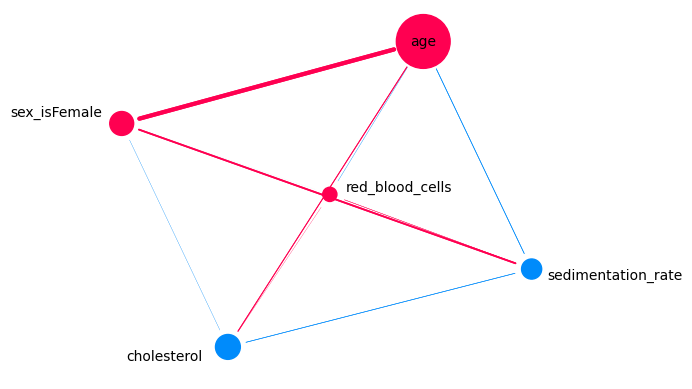


Cluster 1 Network (250 patients)


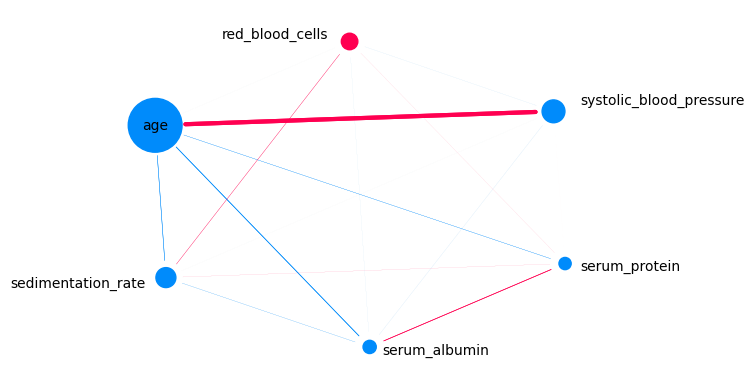


Cluster 2 Network (24 patients)


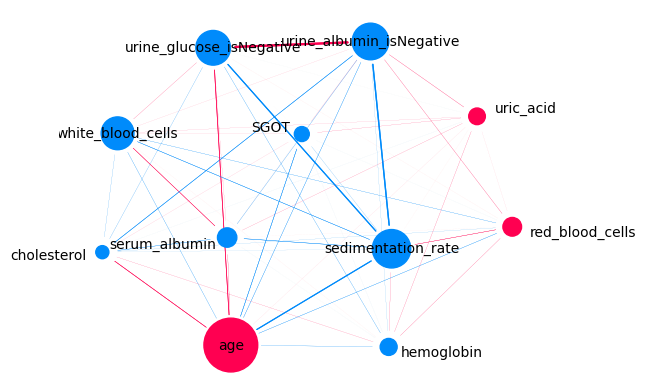


Cluster 3 Network (216 patients)


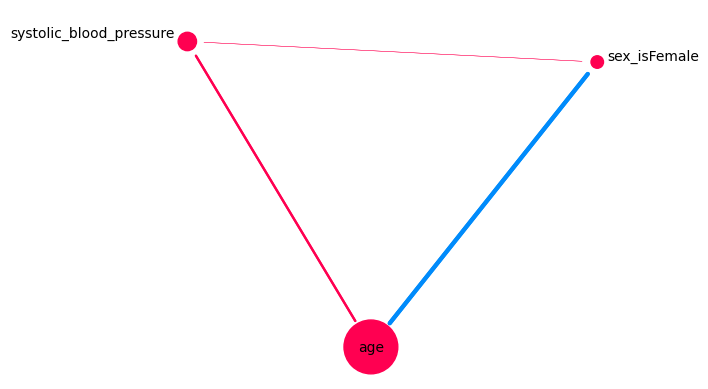

In [35]:
import warnings

warnings.filterwarnings('ignore')

for cluster_id in range(optimal_k):
    print(f"\n{'='*60}")
    print(f"Cluster {cluster_id} Network ({cluster_networks[cluster_id]['n_patients']} patients)")
    print('='*60)
    
    draw(
        psi=cluster_networks[cluster_id]['psi_2'],
        r=cluster_networks[cluster_id]['r_2'],
        positive_alpha=positive_alpha,
        negative_alpha=negative_alpha,
        positive_beta=positive_beta,
        negative_beta=negative_beta,
        negative_color=negative_color,
        positive_color=positive_color,
        label_color='black',
        label_weight='normal',
        plot_margin=0.05
    )

## Comparative Analysis: Top Features by Cluster

In [24]:
# Compare top features across clusters
def get_top_features(psi, n=10):
    return psi['value'].abs().nlargest(n)

print("\nTop 10 Features by Cluster Phenotype:\n")
for cluster_id in range(optimal_k):
    print(f"CLUSTER {cluster_id} ({cluster_networks[cluster_id]['n_patients']} patients):")
    top_features = get_top_features(cluster_networks[cluster_id]['psi_1'])
    for idx, (feature, value) in enumerate(top_features.items(), 1):
        print(f"  {idx}. {feature}: {value:.4f}")
    print()


Top 10 Features by Cluster Phenotype:

CLUSTER 0 (10 patients):
  1. age: 1.0000
  2. cholesterol: 0.2136
  3. sex_isFemale: 0.1974
  4. sedimentation_rate: 0.1397
  5. red_blood_cells: 0.0699
  6. white_blood_cells: 0.0489
  7. uric_acid: 0.0359
  8. serum_protein: 0.0338
  9. eosinophils: 0.0330
  10. urine_albumin_isNegative: 0.0174

CLUSTER 1 (250 patients):
  1. age: 1.0000
  2. systolic_blood_pressure: 0.1801
  3. sedimentation_rate: 0.1374
  4. red_blood_cells: 0.0942
  5. serum_albumin: 0.0603
  6. serum_protein: 0.0515
  7. cholesterol: 0.0420
  8. white_blood_cells: 0.0268
  9. uric_acid: 0.0265
  10. hemoglobin: 0.0235

CLUSTER 2 (24 patients):
  1. age: 1.0000
  2. sedimentation_rate: 0.5097
  3. urine_albumin_isNegative: 0.4633
  4. urine_glucose_isNegative: 0.4156
  5. white_blood_cells: 0.3721
  6. serum_albumin: 0.1295
  7. red_blood_cells: 0.1204
  8. hemoglobin: 0.0995
  9. uric_acid: 0.0955
  10. SGOT: 0.0775

CLUSTER 3 (216 patients):
  1. age: 1.0000
  2. systolic

## Cluster Characterization by Original Features

In [25]:
# Characterize clusters by original feature values
X_with_clusters = X_shapley.copy()
X_with_clusters['cluster'] = cluster_labels

# Calculate mean feature values per cluster
cluster_profiles = X_with_clusters.groupby('cluster').mean()

print("\nCluster Profiles (mean feature values):\n")
print(cluster_profiles.T)


Cluster Profiles (mean feature values):

cluster                              0              1              2  \
sex_isFemale                  0.700000       0.500000       0.541667   
age                          48.200000      59.084000      51.291667   
physical_activity             3.000000       2.848000       2.875000   
serum_albumin                 4.200000       4.207317       4.160000   
alkaline_phosphatase               NaN      63.357143      55.666667   
...                                ...            ...            ...   
uric_acid_isTestnotdone       1.000000       0.004000       0.000000   
systolic_blood_pressure     139.000000     147.484000     137.833333   
pulse_pressure               56.600000      59.900000      55.833333   
bmi                          26.974405      26.816282      26.178617   
rand                     368679.824931  506521.614202  504223.081257   

cluster                              3  
sex_isFemale                  0.694444  
age        

## Feature Importance Differences Between Clusters

In [26]:
# Identify features with largest importance differences between clusters
importance_matrix = pd.DataFrame()
for cluster_id in range(optimal_k):
    importance_matrix[f'Cluster_{cluster_id}'] = cluster_networks[cluster_id]['psi_1']['value'].abs()

# Calculate variance in importance across clusters
importance_matrix['variance'] = importance_matrix.var(axis=1)
importance_matrix['max_diff'] = importance_matrix.iloc[:, :optimal_k].max(axis=1) - importance_matrix.iloc[:, :optimal_k].min(axis=1)

print("\nFeatures with Largest Importance Differences Across Clusters:")
print(importance_matrix.nlargest(15, 'max_diff')[['variance', 'max_diff'] + [f'Cluster_{i}' for i in range(optimal_k)]])


Features with Largest Importance Differences Across Clusters:
                          variance  max_diff  Cluster_0  Cluster_1  Cluster_2  \
sedimentation_rate        0.047353  0.506212   0.139732   0.137408   0.509710   
urine_albumin_isNegative  0.050680  0.456613   0.017371   0.015386   0.463292   
urine_glucose_isNegative  0.040643  0.409299   0.016670   0.014613   0.415648   
white_blood_cells         0.028782  0.347425   0.048922   0.026813   0.372050   
cholesterol               0.008193  0.203346   0.213586   0.041989   0.059282   
sex_isFemale              0.007107  0.177707   0.197408   0.019701   0.021594   
systolic_blood_pressure   0.006016  0.176739   0.003400   0.180139   0.048207   
serum_albumin             0.003421  0.127217   0.002253   0.060347   0.129470   
red_blood_cells           0.002003  0.105032   0.069893   0.094172   0.120444   
hemoglobin                0.001955  0.093980   0.008415   0.023474   0.099495   
uric_acid                 0.001436  0.087703  